c:\Users\Hardik\envs\final\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.75704	test-mlogloss:1.75573
[1]	train-mlogloss:1.63880	test-mlogloss:1.63728
[2]	train-mlogloss:1.55011	test-mlogloss:1.54823
[3]	train-mlogloss:1.47719	test-mlogloss:1.47547
[4]	train-mlogloss:1.42095	test-mlogloss:1.41900
[5]	train-mlogloss:1.37465	test-mlogloss:1.37270
[6]	train-mlogloss:1.33283	test-mlogloss:1.33070
[7]	train-mlogloss:1.29720	test-mlogloss:1.29475
[8]	train-mlogloss:1.26730	test-mlogloss:1.26487
[9]	train-mlogloss:1.23992	test-mlogloss:1.23785
[10]	train-mlogloss:1.21375	test-mlogloss:1.21194
[11]	train-mlogloss:1.19176	test-mlogloss:1.18978
[12]	train-mlogloss:1.17036	test-mlogloss:1.16865
[13]	train-mlogloss:1.14734	test-mlogloss:1.14556
[14]	train-mlogloss:1.12937	test-mlogloss:1.12770
[15]	train-mlogloss:1.11182	test-mlogloss:1.11056
[16]	train-mlogloss:1.09355	test-mlogloss:1.09202
[17]	train-mlogloss:1.07686	test-mlogloss:1.07511
[18]	train-mlogloss:1.06235	test-mlogloss:1.06094
[19]	train-mlogloss:1.04907	test-mlogloss:1.04777
[20]	train

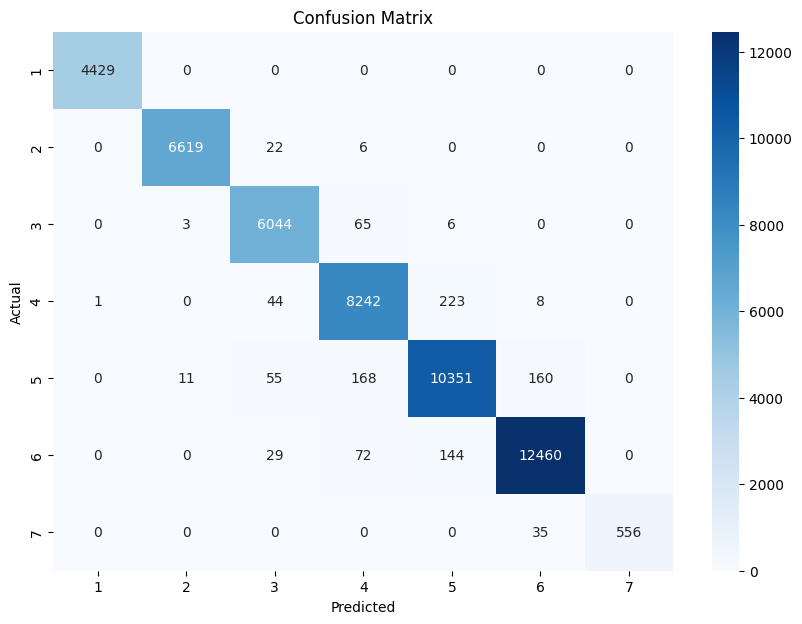

In [1]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file containing p-values
df = pd.read_csv('final.csv')  # Replace with the actual file path


X = df.iloc[:, :-1]
y = df.iloc[:, -1].astype(int) - 1 



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


dtrain = xgb.DMatrix(X_train,y_train,enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

params = {
    'max_depth':2,
    'eta':0.3,
    'objective':'multi:softprob',
    'num_class':7,
    'eval_metric': 'mlogloss'
}


epoch=500
eval_res={}
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params,dtrain,epoch,evals,evals_result=eval_res)

# Make predictions using the trained model
y_pred_probs = model.predict(dtest)  # Get probabilities for each class

# Convert probabilities to class labels
y_pred = y_pred_probs.argmax(axis=1)  # Get class labels by taking argmax

# Save the model
model.save_model('xgboost_final.json')

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))  # Now y_pred is the predicted class labels
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7], yticklabels=[1, 2, 3, 4, 5, 6, 7])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


